In [1]:
from torchvision import models, datasets
import torch
import torchvision.transforms as T
import torch.nn.utils.prune as prune
from tqdm.notebook import tqdm

In [2]:
import sys
sys.path.insert(0, "./../")

In [3]:
from src.model import get_model_instance_segmentation
from src.test_utils import test_model_on_dataset, get_inference_time, get_model_prediction_one_image
from src.references.detection import coco_utils
import src.references.detection.transforms as TL
from src.visual_utils import show_coco_dataset_item, show_instance_segmentation_by_model_predictions

In [4]:
COCO_ROOT_PATH = "/data"

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu_device = torch.device("cpu")
device = cpu_device

### Load dataset

In [7]:
common_transforms = TL.Compose([TL.ToTensor()])

dataset = coco_utils.get_coco(COCO_ROOT_PATH, "val", common_transforms)

loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


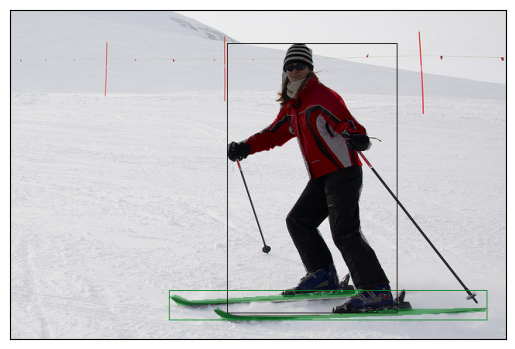

In [8]:
show_coco_dataset_item(dataset[5])

### Load model

In [23]:
model = get_model_instance_segmentation()

In [32]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024 ** 2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 169.783MB


In [30]:
model = model.to(device)
model_q = torch.quantization.quantize_dynamic(
    model,
#     {torch.nn.Conv2d},
      {torch.nn.Conv2d, torch.nn.Linear},
    dtype=torch.qint8
)

### Test inference on one image

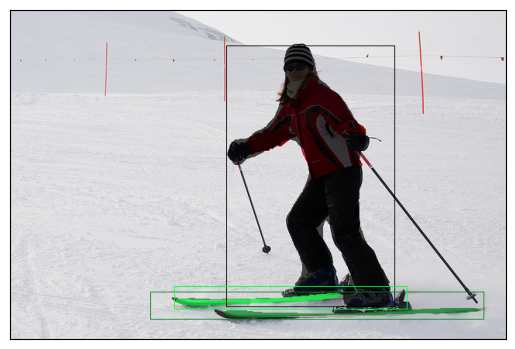

In [31]:
item_index = 5
img = dataset[item_index][0]
pred = get_model_prediction_one_image(img, model_q, device)
show_instance_segmentation_by_model_predictions(img, pred)

In [12]:
pred

{'boxes': array([[279.39432 ,  47.483322, 496.8908  , 383.60977 ],
        [181.45444 , 364.00745 , 611.63495 , 399.531   ],
        [212.28217 , 357.46817 , 512.04456 , 386.1752  ],
        [257.66473 , 378.35745 , 623.3795  , 401.51355 ],
        [209.99318 , 368.25824 , 451.30344 , 399.9847  ],
        [459.7522  ,  57.646896, 462.99814 ,  62.65933 ],
        [633.5096  ,  61.781063, 636.7739  ,  66.82733 ],
        [409.80975 , 382.9821  , 620.41693 , 394.39267 ],
        [312.87558 , 364.03876 , 449.96152 , 379.29828 ],
        [298.12814 , 349.2525  , 556.1408  , 407.32947 ],
        [212.61617 , 368.1734  , 372.12555 , 382.0969  ],
        [ 12.408151,  64.590416,  15.449765,  68.12145 ],
        [209.53433 ,  64.3915  , 212.7469  ,  68.20687 ],
        [193.41223 , 342.99774 , 544.6444  , 392.5951  ]], dtype=float32),
 'labels': array([ 1, 35, 35, 35, 35,  1, 10, 35, 35, 35, 35, 38, 38, 35]),
 'scores': array([0.9998385 , 0.9447114 , 0.7613252 , 0.39611492, 0.2616772 ,
        

### Measure model performance

In [14]:
a = test_model_on_dataset(model_q, dataset, device)

Test:  [  0/100]  eta: 0:17:57  model_time: 10.5922 (10.5922)  evaluator_time: 0.1300 (0.1300)  time: 10.7715  data: 0.0491  max mem: 0
Test:  [ 99/100]  eta: 0:00:08  model_time: 8.3077 (8.6088)  evaluator_time: 0.0496 (0.0531)  time: 8.6718  data: 0.0302  max mem: 0
Test: Total time: 0:14:28 (8.6884 s / it)
Averaged stats: model_time: 8.3077 (8.6088)  evaluator_time: 0.0496 (0.0531)
Accumulating evaluation results...
DONE (t=0.59s).
Accumulating evaluation results...
DONE (t=0.53s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.466
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.656
 Average Reca

In [12]:
model = model.to(device)
model = model.eval()
total_time = 0
for i, dataset_item in tqdm(enumerate(dataset), total=len(dataset)):
    if i == len(dataset):
        break
    input_image = dataset_item[0]
    img = input_image.to(device)
    item_time = get_inference_time(img, model, device)
    total_time += item_time
print(f"Mean time: {total_time / len(dataset)}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean time: 0.361413791179657


In [1]:
model

NameError: name 'model' is not defined